# PREMIERE PROJECT : Airplane Crash Since 1908

Team Pyscript
© HDSC FALL 2022

---

I **Oladimeji WILLIAMS**, confirm - by submitting this document - that the solutions in this notebook are a result of my team's work (team Pyscript), and that I abide by the [Code of Conduct](https://drive.google.com/file/d/1sbR80aowp1daCnElwx3kNm0fxids0e6b/view) contained therein.



### Overview: Airplane Crash Since 1908
>The [dataset](https://www.kaggle.com/datasets/cgurkan/airplane-crash-data-since-1908) contains over 4000 cases of airplane crashes since 1908.

Date: Date of accident, in the format - January 01, 2001
Time: Local time, in 24 hr. format unless otherwise specified
Airline/Op: Airline or operator of the aircraft
Flight #: Flight number assigned by the aircraft operator
Route: Complete or partial route flown prior to the accident
AC Type: Aircraft type
Reg: ICAO registration of the aircraft
cn / ln: Construction or serial number / Line or fuselage number
Aboard: Total aboard (passengers / crew)
Fatalities: Total fatalities aboard (passengers / crew)
Ground: Total killed on the ground
Summary: Brief description of the accident and cause if known

Target Variable: A new calculated column is created called "Severity", if 1 means the crash is severe, and if 0 means that the crash is not severe.



        
- **The supporting visualization of this project on *tableau dashboard* can be found [here](https://public.tableau.com/views/AirplaneCrash_16711130319430/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link).**

# Preliminaries

In [ ]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import nltk
import gensim.downloader as gensim_api
import gensim
import seaborn as sns
import string
import pickle as pk
import re
import wordcloud
import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import xgboost
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from wordcloud import WordCloud, STOPWORDS
import io
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
uploaded = files.upload()

Saving Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv to Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
# Load the dateset
df = pd.read_csv(io.BytesIO(uploaded["Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv"]), parse_dates=[0, 1])

In [ ]:
# Copy the dataset into another dataframe
df_copy = df.copy()

In [ ]:
# Peak the datatypes
df.dtypes

Date                     datetime64[ns]
Time                             object
Location                         object
Operator                         object
Flight #                         object
Route                            object
AC Type                          object
Registration                     object
cn/ln                            object
Aboard                          float64
Aboard Passangers               float64
Aboard Crew                     float64
Fatalities                      float64
Fatalities Passangers           float64
Fatalities Crew                 float64
Ground                          float64
Summary                          object
dtype: object

In [ ]:
df.isnull().sum()

Date                        0
Time                     1510
Location                    4
Operator                   10
Flight #                 3652
Route                     774
AC Type                    15
Registration              273
cn/ln                     668
Aboard                     18
Aboard Passangers         229
Aboard Crew               226
Fatalities                  8
Fatalities Passangers     242
Fatalities Crew           241
Ground                     41
Summary                    64
dtype: int64

In [ ]:
#Create a function to clean dataset and return cleaned and pre-processed dataset in a dataframe
def preprocess(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Year'] = dataframe['Date'].dt.year
    dataframe["Month"] = dataframe["Date"].dt.month    
    return dataframe

In [ ]:
df = preprocess(df)

In [ ]:
## Add a categorical column named `severity` which is 1 when the number of fatalities is at least 50% of the number of people that boarded the plane
df['Severity'] = (df['Fatalities'] >= (0.5 * df['Aboard'])).astype(int)

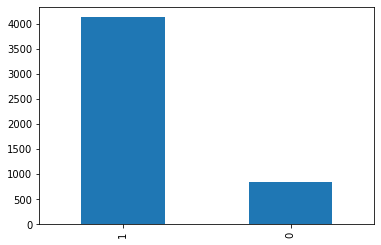

1    4125
0     842
Name: Severity, dtype: int64

In [ ]:
df.Severity.value_counts().plot(kind = "bar")
plt.show()
#Actual values of severity. 1 represents positive, 0 represents negative. That is, severe crashes or not severe crashes
df['Severity'].value_counts()

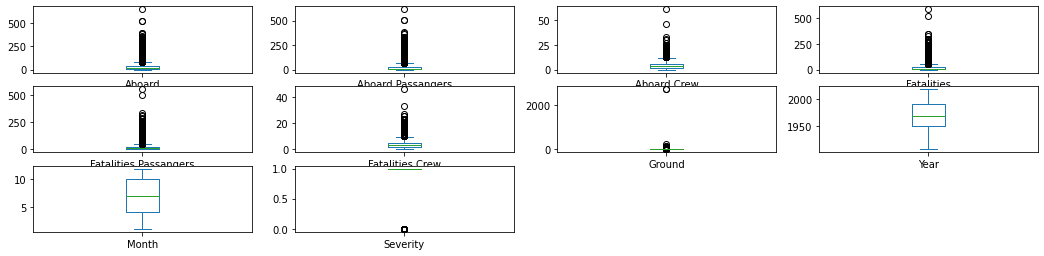

In [ ]:
#Check for outliers
df.plot(kind='box', subplots=True, layout=(7,4), sharex=False, sharey=False, figsize=(18,10));
plt.show()

In [ ]:
#Find index position of outlier in df['Ground']
df['Ground'].sort_values().tail()

2412   NaN
2971   NaN
4709   NaN
4742   NaN
4917   NaN
Name: Ground, dtype: float64

In [ ]:
#Remove outlier based on index position
df.drop([4328, 4329], inplace=True)

In [ ]:
#See correlation of features
correl = df.corr()
correl

,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Year,Month,Severity
Aboard,1.000000,0.997987,0.610924,0.741518,0.748573,0.324122,-0.003666,0.210010,0.025999,-0.199798
Aboard Passangers,0.997987,1.000000,0.561767,0.740837,0.749038,0.280569,-0.003354,0.211568,0.028871,-0.198510
Aboard Crew,0.610924,0.561767,1.000000,0.480843,0.434242,0.760551,0.024465,0.110544,0.006403,-0.095598
Fatalities,0.741518,0.740837,0.480843,1.000000,0.992986,0.575587,0.004333,0.161171,0.015242,0.200291
Fatalities Passangers,0.748573,0.749038,0.434242,0.992986,1.000000,0.511708,0.004927,0.163972,0.018751,0.178351
Fatalities Crew,0.324122,0.280569,0.760551,0.575587,0.511708,1.000000,0.024634,0.064092,-0.004235,0.336138
Ground,-0.003666,-0.003354,0.024465,0.004333,0.004927,0.024634,1.000000,0.036125,0.001058,-0.019518
Year,0.210010,0.211568,0.110544,0.161171,0.163972,0.064092,0.036125,1.000000,-0.032924,-0.054553
Month,0.025999,0.028871,0.006403,0.015242,0.018751,-0.004235,0.001058,-0.032924,1.000000,-0.005198
Severity,-0.199798,-0.198510,-0.095598,0.200291,0.178351,0.336138,-0.019518,-0.054553,-0.005198,1.000000


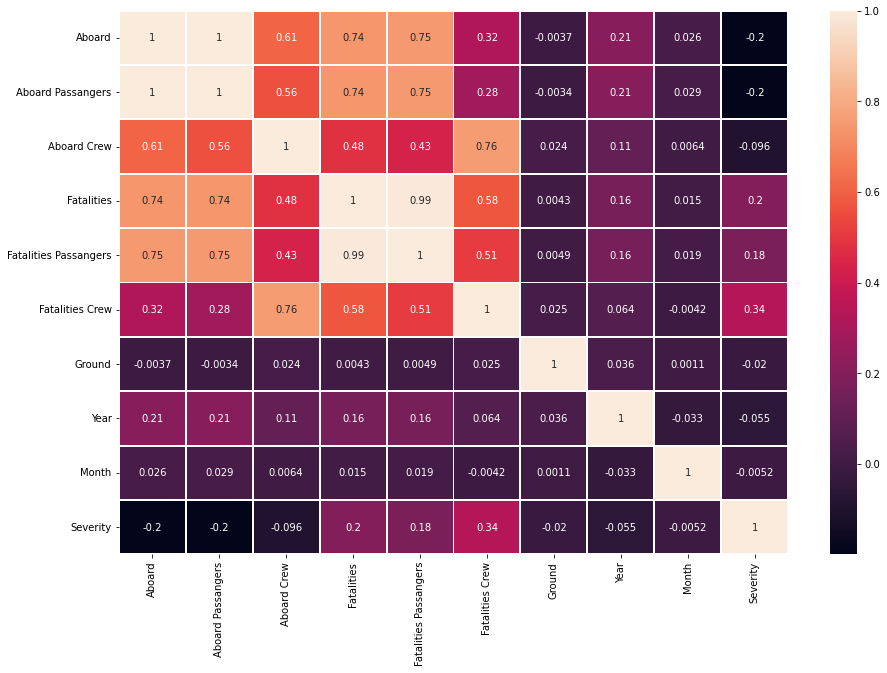

In [ ]:
#Visualize the correlation
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(correl, linewidths=1, annot=True, color='r')

In [ ]:
#See highest number of airplane crashes by year
df['Year'].value_counts().head(10)

1946    88
1989    83
1947    82
1948    77
1962    77
1972    77
1951    75
1994    74
1945    74
1970    73
Name: Year, dtype: int64

(array([ 33., 208., 383., 735., 708., 698., 583., 705., 585., 327.]),
 array([1908. , 1919.1, 1930.2, 1941.3, 1952.4, 1963.5, 1974.6, 1985.7,
        1996.8, 2007.9, 2019. ]),
 <a list of 10 Patch objects>)

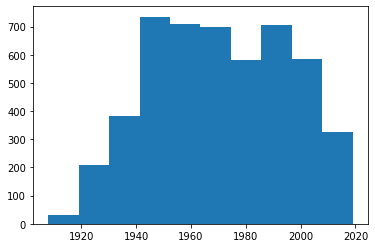

In [ ]:
#Histogram showing airplane crashes based on year
plt.hist(df['Year'])

Text(0.5, 1.0, 'Aboard vs. Fatalities')

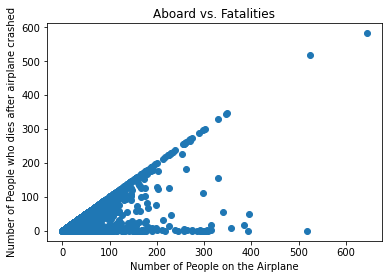

In [ ]:
#See relationship between aboard and fatalities
plt.scatter(x=df['Aboard'], y=df['Fatalities'])
plt.xlabel('Number of People on the Airplane')
plt.ylabel('Number of People who dies after airplane crashed')
plt.title('Aboard vs. Fatalities')

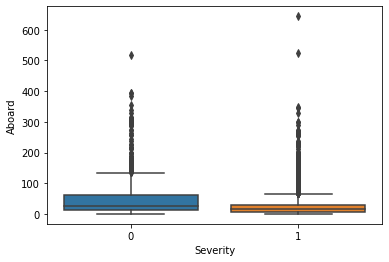

In [ ]:
#Visualization between a discontinuous variable and a continuous variable
sns.boxplot(x='Severity', y='Aboard', data=df)

In [ ]:
df[df["Fatalities"].isna() & df["Fatalities Crew"].notna()]

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary,Year,Month,Severity


In [ ]:
df[df["Aboard"].isna() & df["Aboard Passangers"].notna()]

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary,Year,Month,Severity


In [ ]:
round(((df.isnull().sum() / df.shape[0]) * 100), 1)

Date                      0.0
Time                     30.4
Location                  0.1
Operator                  0.2
Flight #                 73.6
Route                    15.6
AC Type                   0.3
Registration              5.5
cn/ln                    13.5
Aboard                    0.4
Aboard Passangers         4.6
Aboard Crew               4.6
Fatalities                0.2
Fatalities Passangers     4.9
Fatalities Crew           4.9
Ground                    0.8
Summary                   1.3
Year                      0.0
Month                     0.0
Severity                  0.0
dtype: float64

In [ ]:
df = df.dropna()

In [ ]:
df_new = df.copy()
airtraffic = df["Summary"].str.contains("air traffic", case = False)
df_new.loc[airtraffic, "category"] = "air traffic"
bird = df["Summary"].str.contains("bird", case = False)
df_new.loc[bird, "category"] = "bird strikes"
cargohold = df["Summary"].str.contains("cargo hold|cabin|fire", regex = True, case = False)
df_new.loc[cargohold, "category"] = "cargo hold / fire"
designflaws = df["Summary"].str.contains("design flaw", regex = True, case = False)
df_new.loc[designflaws, "category"] = "design flaws"
fuelstarvation = df["Summary"].str.contains("fuel|starvation", regex = True, case = False)
df_new.loc[fuelstarvation, "category"] = "fuel starvation"
storm = df["Summary"].str.contains("lightning|storm", regex = True, case = False)
df_new.loc[storm, "category"] = "lightning / storm"
incapacitation = df["Summary"].str.contains("incapacitation", regex = True, case = False)
df_new.loc[incapacitation, "category"] = "pilot incapacitation"
hijacking = df["Summary"].str.contains("sabotage|hijacking", regex = True, case = False)
df_new.loc[hijacking, "category"] = "hijacking / sabotage"

In [ ]:
df_new.head()

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,...,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary,Year,Month,Severity,category
217,1930-01-19,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,...,2.0,16.0,14.0,2.0,0.0,"While en route to Los Angeles, the pilot, flyi...",1930,1,1,NaN
247,1931-03-31,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,...,2.0,8.0,6.0,2.0,0.0,"Shortly after taking off from Kansas City, one...",1931,3,1,lightning / storm
348,1934-08-31,22:45,"Amazonia, Missouri",Rapid Air Transport,6,Kansas City - Saint Joseph - Omaha,Stinson SM-6000B,NC11118,5004,5.0,...,1.0,5.0,4.0,1.0,0.0,The plane crashed about 11 miles from St. Jose...,1934,8,1,NaN
370,1935-05-06,03:30,"Atlanta, Missouri",Trans Continental and Western Air,6,Los Angeles - Albuquerque - Kanasas City - Wa...,Douglas DC-2-112,NC13785,1295,14.0,...,2.0,5.0,3.0,2.0,0.0,The plane crashed while en route from Albuquer...,1935,5,0,fuel starvation
384,1935-08-14,23:45,"Near Gilmer, Texas",Delta Air Lines,4,Dallas - Atlanta,Stinson Model A,NC14599,9103,4.0,...,1.0,4.0,3.0,1.0,0.0,Crashed 3 miles south of Gilmer. The outboard ...,1935,8,1,NaN


In [ ]:
df_new = df.copy()
airtraffic = df["Summary"].str.contains("air traffic", case = False)
df_new.loc[airtraffic, "category"] = "air traffic"
bird = df["Summary"].str.contains("bird", case = False)
df_new.loc[bird, "category"] = "bird strikes"
cargohold = df["Summary"].str.contains("cargo hold|cabin|fire", regex = True, case = False)
df_new.loc[cargohold, "category"] = "cargo hold / fire"
designflaws = df["Summary"].str.contains("design flaw", regex = True, case = False)
df_new.loc[designflaws, "category"] = "design flaws"
fuelstarvation = df["Summary"].str.contains("fuel|starvation", regex = True, case = False)
df_new.loc[fuelstarvation, "category"] = "fuel starvation"
storm = df["Summary"].str.contains("lightning|storm", regex = True, case = False)
df_new.loc[storm, "category"] = "lightning / storm"
incapacitation = df["Summary"].str.contains("incapacitation", regex = True, case = False)
df_new.loc[incapacitation, "category"] = "pilot incapacitation"
hijacking = df["Summary"].str.contains("sabotage|hijacking", regex = True, case = False)
df_new.loc[hijacking, "category"] = "hijacking / sabotage"

In [ ]:
df1 = df[["Date", "Year", "Month", "Time", "AC Type", "Fatalities", "Summary", "Severity"]]

In [ ]:
#nltk.download('STOPWORDS')
stop_words = nltk.corpus.stopwords.words('english')

# Relevant Functions

In [ ]:
# remove stopwords and irrelevant characters

def remove_stopwords(row):
    sentence = row['Summary']
    modified = []
    sentence = re.sub(r'<[a-z]+>', '', sentence)
    sentence = re.sub(r'\n', '', sentence)
    for p in string.punctuation:
        sentence = sentence.replace(p, '')
    for word in sentence.split():
        if word not in stop_words:
            modified.append(word)
    return ' '.join(modified).lower()

In [ ]:
# create 7 model objects

lr = LogisticRegression()
dt = DecisionTreeClassifier()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
xgb = xgboost.XGBClassifier()
cbt = CatBoostClassifier()
svm = SVC()

models = [lr, dt, gb, rf, xgb, cbt, svm]
# models = [lr, dt, gb, rf, svm]

names = ['LogisticRegression', 'DecisionTree', 'GradientBoosting', 'RandomForest', 'XGB', 'CATBoost', 'SupportVectorMachine']
# names = ['LogisticRegression', 'DecisionTree', 'GradientBoosting', 'RandomForest', 'SupportVectorMachine']

In [ ]:
# evaluate models

def evaluate_models(xTrain, yTrain, xVal, yVal, feature = "", models = []):
    xs = [xTrain, yTrain, xVal, yVal]
    random_seed= 0
    scores = []
    for i in range(len(models)):
        model = models[i] 
        model.fit(xTrain, yTrain)
        y_predicted = model.predict(xVal)
        accuracy = accuracy_score(yVal, y_predicted)
        f1score = f1_score(yVal, y_predicted)
        precision = precision_score(yVal, y_predicted)
        recall = recall_score(yVal, y_predicted)
        scores.append({
            'model':names[i] + ' with ' + feature ,
            'training_score':model.score(xTrain, yTrain),
            'accuracy' : accuracy,
            'f1_score' : f1score,
            'precision': precision,
            'recall' : recall
        })
    return pd.DataFrame(scores, columns=['model','training_score','accuracy','f1_score', 'precision', 'recall'])

In [ ]:
# cross validation

def get_cv(X, y):
    scores = []
    for i in range(len(models)):
        model = models[i]
        cv = np.mean(np.absolute(cross_val_score(model, X, y, cv = 5)))
        scores.append({'model' : names[i],
                      'CV' : cv})
    return pd.DataFrame(scores, columns = ['model', 'CV'])

In [ ]:
df1 = df1.dropna().reset_index(drop = True)
df1["Summary_modified"] = df1.apply(remove_stopwords, axis = 1)
df1["Fatalities"] = df1["Fatalities"].astype(int)

In [ ]:
df1.head()

,Date,Year,Month,Time,AC Type,Fatalities,Summary,Severity,Summary_modified
0,1930-01-19,1930,1,18:23,Ford 5-AT-C Tri Motor,16,"While en route to Los Angeles, the pilot, flyi...",1,while en route los angeles pilot flying low al...
1,1931-03-31,1931,3,10:45,Fokker F10A Trimotor,8,"Shortly after taking off from Kansas City, one...",1,shortly taking kansas city one aircrafts wings...
2,1934-08-31,1934,8,22:45,Stinson SM-6000B,5,The plane crashed about 11 miles from St. Jose...,1,the plane crashed 11 miles st joseph heavy fog...
3,1935-05-06,1935,5,03:30,Douglas DC-2-112,5,The plane crashed while en route from Albuquer...,0,the plane crashed en route albuquerque kansas ...
4,1935-08-14,1935,8,23:45,Stinson Model A,4,Crashed 3 miles south of Gilmer. The outboard ...,1,crashed 3 miles south gilmer the outboard engi...


In [ ]:
print(df1['Summary'].iloc[0])
print('----')
print(df1['Summary_modified'].iloc[0])

While en route to Los Angeles, the pilot, flying a low altitude due to poor weather conditions tried to turn back. While in a left turn his left wing struck a hill, crashed and burned. Adverse weather conditions. The plane flew into a sudden squall which cause the pilot to lose control.
----
while en route los angeles pilot flying low altitude due poor weather conditions tried turn back while left turn left wing struck hill crashed burned adverse weather conditions the plane flew sudden squall cause pilot lose control


# Model Building

In [ ]:
df1.isnull().sum()

Date                0
Year                0
Month               0
Time                0
AC Type             0
Fatalities          0
Summary             0
Severity            0
Summary_modified    0
dtype: int64

In [ ]:
# X = df1.reset_index()[["AC Type", "Fatalities", "Summary_modified"]]
X = df1.reset_index()[["Fatalities", "AC Type", "Summary_modified"]]
y = df1.reset_index()['Severity']

In [ ]:
#stratify y to maintain distribution of the target to reduce over fit
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.4)

## TFIDF

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
tfidf_models = [lr, dt, gb, rf, svm]

In [ ]:
tfidfX_train1 = pd.DataFrame(tfidf.fit_transform(X_train['Summary_modified']).toarray())
# tfidfX_train2 = pd.DataFrame(tfidf.fit_transform(X_train['AC Type']).toarray())
tfidfX_train = pd.concat([tfidfX_train1, X_train.reset_index()["Fatalities"]], axis = 1)

tfidfX_test1 = pd.DataFrame(tfidf.transform(X_test['Summary_modified']).toarray())
# tfidfX_test2 = pd.DataFrame(tfidf.transform(X_test['AC Type']).toarray())
tfidfX_test = pd.concat([tfidfX_test1, X_test.reset_index()['Fatalities']], axis = 1)

In [ ]:
model_results = evaluate_models(tfidfX_train, y_train, tfidfX_test, y_test, feature = 'Tfidf', models = tfidf_models)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

In [ ]:
model_results

,model,training_score,accuracy,f1_score,precision,recall
0,LogisticRegression with Tfidf,0.928087,0.880081,0.927961,0.881671,0.979381
1,DecisionTree with Tfidf,1.000000,0.845528,0.903308,0.891960,0.914948
2,GradientBoosting with Tfidf,0.987788,0.878049,0.925743,0.890476,0.963918
3,RandomForest with Tfidf,1.000000,0.845528,0.910588,0.837662,0.997423
4,SupportVectorMachine with Tfidf,0.786974,0.788618,0.881818,0.788618,1.000000


In [ ]:
# tfidfX_train1 = pd.DataFrame(tfidf.fit_transform(X_train['Summary_modified']).toarray())
tfidfX_train2 = pd.DataFrame(tfidf.fit_transform(X_train['AC Type']).toarray())
tfidfX_train = pd.concat([tfidfX_train2, X_train.reset_index()["Fatalities"]], axis = 1)

tfidfX_test1 = pd.DataFrame(tfidf.transform(X_test['Summary_modified']).toarray())
# tfidfX_test2 = pd.DataFrame(tfidf.transform(X_test['AC Type']).toarray())
tfidfX_test = pd.concat([tfidfX_test, X_test.reset_index()['Fatalities']], axis = 1)

In [ ]:
model_results = evaluate_models(tfidfX_train, y_train, tfidfX_test, y_test, feature = 'Tfidf', models = tfidf_models)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: ignored

In [ ]:
model_results

## Using Bag of Words

In [ ]:
cv = CountVectorizer()

In [ ]:
bow_models = [lr, dt, gb, rf, svm]

In [ ]:
bow_train1 = pd.DataFrame(cv.fit_transform(X_train['Summary_modified']).toarray())
# bow_train2 = pd.DataFrame(cv.fit_transform(X_train['AC Type']).toarray())
bow_train = pd.concat([bow_train1, X_train.reset_index()["Fatalities"]], axis = 1)

bow_test1 = pd.DataFrame(cv.transform(X_test['Summary_modified']).toarray())
# bow_test2 = pd.DataFrame(cv.transform(X_test['AC Type']).toarray())
bow_test = pd.concat([bow_test1, X_test.reset_index()['Fatalities']], axis = 1)

In [ ]:
model_results = evaluate_models(bow_train, y_train, bow_test, y_test, feature = 'bag of words', models = bow_models)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/l

In [ ]:
model_results

,model,training_score,accuracy,f1_score,precision,recall
0,LogisticRegression with bag of words,0.994573,0.849593,0.908189,0.875598,0.943299
1,DecisionTree with bag of words,1.000000,0.841463,0.900256,0.893401,0.907216
2,GradientBoosting with bag of words,0.971506,0.886179,0.931204,0.889671,0.976804
3,RandomForest with bag of words,1.000000,0.843496,0.908876,0.840263,0.989691
4,SupportVectorMachine with bag of words,0.786974,0.788618,0.881818,0.788618,1.000000


All the results above clearly that the models are overfitting

## Without Categorical Variables

In [ ]:
models = [lr, dt, gb, rf, xgb, cbt, svm]

In [ ]:
df2 = df[["Month", "Fatalities", "Severity"]]

In [ ]:
# X = df1.reset_index()[["AC Type", "Fatalities", "Summary_modified"]]
X = df2.drop(["Severity"], axis = 1)
y = df2["Severity"]

In [ ]:
get_cv(X, y)

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6538453	total: 58.8ms	remaining: 11.7s
5:	learn: 0.6466102	total: 60.1ms	remaining: 9.95s
6:	learn: 0.6388432	total: 61.3ms	remaining: 8.7s
7:	learn: 0.6333508	total: 62.2ms	remaining: 7.71s
8:	learn: 0.6269405	total: 65.2ms	remaining: 7.18s
9:	learn: 0.6202593	total: 66.5ms	remaining: 6.59s
10:	learn: 0.6140915	total: 68.2ms	remaining: 6.13s
11:	learn: 0.6080133	total: 69.7ms	remaining: 5.74s
12:	learn: 0.6018385	total: 71.2ms	remaining: 5.4s
13:	learn: 0.5963267	total: 72.6ms	remaining: 5.11s
14:	learn: 0.5906582	total: 74ms	remaining: 4.86s
15:	learn: 0.5851198	total: 75.6ms	remaining: 4.65s
16:	learn: 0.5794305	total: 77.1ms	remaining: 4.46s
17:	learn: 0.5743993	total: 78.5ms	remaining: 4.29s
18:	learn: 0.5688191	total: 80ms	remaining: 4.13s
19:	learn: 0.5637789	total: 81.6ms	remaining: 4s
20:	learn: 0.5584724	total: 83.1ms	remaining: 3.87s
21:	learn: 0.5535794	total: 84.6ms	remaining: 3.76s
22:	learn: 0.5486722	total: 

,model,CV
0,LogisticRegression,0.815314
1,DecisionTree,0.759940
2,GradientBoosting,0.834797
3,RandomForest,0.799811
4,XGB,0.839678
5,CATBoost,0.839675
6,SupportVectorMachine,0.799034


In [ ]:
#stratify y to maintain distribution of the target to reduce over fit
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)

In [ ]:
model_results = evaluate_models(X_train, y_train, X_test, y_test, models = models)

Learning rate set to 0.00966
0:	learn: 0.6854684	total: 3.2ms	remaining: 3.2s
1:	learn: 0.6779286	total: 4.31ms	remaining: 2.15s
2:	learn: 0.6710398	total: 5.76ms	remaining: 1.91s
3:	learn: 0.6640957	total: 7.17ms	remaining: 1.78s
4:	learn: 0.6567741	total: 8.59ms	remaining: 1.71s
5:	learn: 0.6499452	total: 10.1ms	remaining: 1.67s
6:	learn: 0.6433514	total: 11.9ms	remaining: 1.69s
7:	learn: 0.6368377	total: 13.3ms	remaining: 1.65s
8:	learn: 0.6309699	total: 14.8ms	remaining: 1.63s
9:	learn: 0.6247858	total: 16.2ms	remaining: 1.6s
10:	learn: 0.6188833	total: 17.6ms	remaining: 1.58s
11:	learn: 0.6128462	total: 18.9ms	remaining: 1.55s
12:	learn: 0.6077122	total: 20.3ms	remaining: 1.54s
13:	learn: 0.6029284	total: 21.7ms	remaining: 1.53s
14:	learn: 0.5974654	total: 22.9ms	remaining: 1.5s
15:	learn: 0.5917324	total: 24.3ms	remaining: 1.5s
16:	learn: 0.5863988	total: 25.7ms	remaining: 1.49s
17:	learn: 0.5815419	total: 27.4ms	remaining: 1.5s
18:	learn: 0.5759095	total: 29ms	remaining: 1.5s
19

In [ ]:
model_results

,model,training_score,accuracy,f1_score,precision,recall
0,LogisticRegression with,0.813953,0.807588,0.890937,0.805556,0.996564
1,DecisionTree with,0.913953,0.769648,0.845173,0.899225,0.797251
2,GradientBoosting with,0.870930,0.850949,0.909390,0.873418,0.948454
3,RandomForest with,0.913953,0.799458,0.869258,0.894545,0.845361
4,XGB with,0.858140,0.850949,0.909390,0.873418,0.948454
5,CATBoost with,0.870930,0.848238,0.906667,0.880259,0.934708
6,SupportVectorMachine with,0.787209,0.788618,0.881818,0.788618,1.000000


In [ ]:
models[4].predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,